In [13]:
import cv2
import torch
import matplotlib.pyplot as plt
import detectron2


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [2]:
VID_PATH = "TopDown_AerialVideo_1080.mp4"
SAVE_PATH = "TopDown_AerialVideo_1080_persons.mp4"
cap = cv2.VideoCapture(VID_PATH)

assert cap.isOpened(), "Failed to open %s" % VID_PATH
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) 

print("Input video is %dx%d, with fps of %0.3f"% (w,h,fps))


Input video is 1920x1080, with fps of 29.988


True


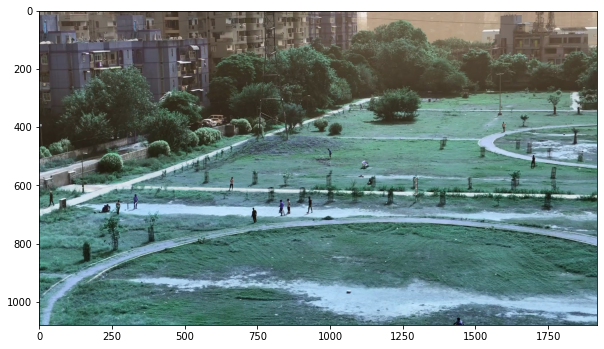

In [3]:
ret, frame = cap.read() 
print(ret)
plt.figure(figsize=(10,10))
plt.imshow(frame)

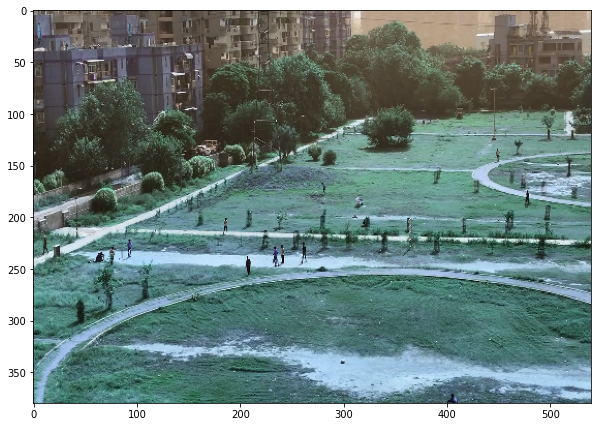

In [4]:
frame_resized = cv2.resize(frame, (540, 380), fx = 0, fy = 0, interpolation = cv2.INTER_CUBIC)
plt.figure(figsize=(10,10))
plt.imshow(frame_resized)

In [5]:
print(torch.cuda.device_count())
device = torch.device("cpu")

1


In [6]:
def build_predictor():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

    # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)
    
    return predictor


tensor([0, 0, 2, 0, 2, 0, 0, 2, 0], device='cuda:0')


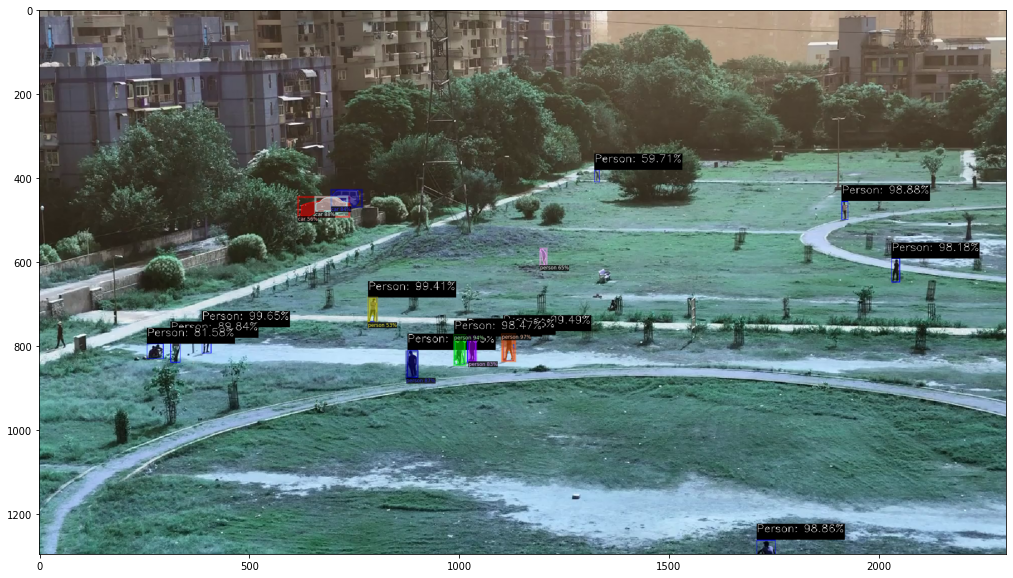

In [15]:
predictor = build_predictor()
outputs = predictor(frame)

print(outputs["instances"].pred_classes)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
v = Visualizer(frame, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(20,10))
plt.imshow(out.get_image())

In [10]:
print(outputs["instances"].to("cpu"))

Instances(num_instances=15, image_height=1080, image_width=1920, fields=[pred_boxes: Boxes(tensor([[ 323.2713,  630.4191,  341.6293,  681.4586],
        [ 731.4399,  675.6609,  751.7345,  729.8674],
        [ 921.2762,  638.3443,  942.8770,  696.9998],
        [ 653.4590,  571.4404,  670.2741,  619.8149],
        [ 850.6299,  645.3432,  866.8983,  699.5910],
        [1593.3544,  380.7507, 1605.8826,  416.9782],
        [1424.8644, 1052.6666, 1461.9795, 1080.0000],
        [ 824.0117,  649.2551,  844.4758,  703.6199],
        [1692.0358,  494.8037, 1708.7163,  540.7554],
        [ 261.5097,  651.5900,  280.7324,  699.9585],
        [ 548.3890,  371.2347,  611.7978,  401.0712],
        [ 580.3326,  357.0181,  641.0389,  390.5379],
        [ 214.4633,  663.7310,  246.1708,  692.2710],
        [1102.0358,  318.1187, 1112.1720,  341.8528],
        [ 513.8950,  370.7967,  615.6439,  410.1529]])), scores: tensor([0.9965, 0.9953, 0.9949, 0.9941, 0.9926, 0.9888, 0.9886, 0.9847, 0.9818,
        

In [11]:
def draw_person_boxes(frame, boxes, probs):
    # for all the boxes:
    for (box, prob) in zip(boxes, probs):
        
        # extract the properties:
        (startX, startY, endX, endY) = box.astype("int")
        label = "{}: {:.2f}%".format("Person", prob * 100)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.7
        thickness = 1
        text_size, _ = cv2.getTextSize(label, font, font_scale, thickness)
        text_w, text_h = text_size
        
        text_color_bg = (0,0,0)
        text_color = (255,255,255)
        box_color = (0,0,255)
        
        # draw the bb prediction on the frame
        cv2.rectangle(frame, (startX, startY), (endX, endY), box_color , 1)
        
        # include text:
        y = startY - text_h if startY - text_h > text_h else startY + text_h
        cv2.rectangle(frame, (startX, y - text_h), (startX + text_w, startY-1), text_color_bg, -1)
        cv2.putText(frame, label, (startX, y), font, font_scale, text_color, thickness)
        
    return frame

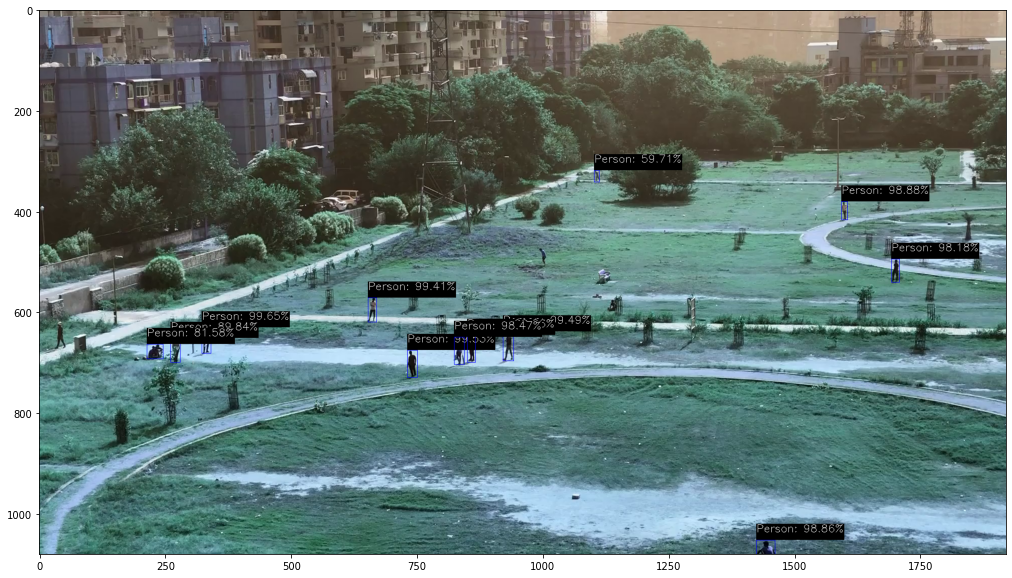

In [12]:
CLASSES = {"Person":0}
predictions = outputs["instances"].to("cpu")
person_idx = [predictions.pred_classes==CLASSES["Person"]]

boxes = predictions.pred_boxes[person_idx].tensor.numpy()
probs = predictions.scores[person_idx].numpy()

box_frame2 = draw_person_boxes(frame, boxes, probs)

plt.figure(figsize=(20,10))
plt.imshow(box_frame2)

In [68]:
count = 1
VID_PATH = "TopDown_AerialVideo_1080.mp4"
SAVE_PATH = "TopDown_AerialVideo_1080_persons.mp4"
cap = cv2.VideoCapture(VID_PATH)
vid_writer = cv2.VideoWriter(SAVE_PATH, fourcc, fps, (w, h))
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    print(count)
    
    outputs = predictor(frame)

    predictions = outputs["instances"].to("cpu")
    person_idx = [predictions.pred_classes==CLASSES["Person"]]

    boxes = predictions.pred_boxes[person_idx].tensor.numpy()
    probs = predictions.scores[person_idx].numpy()

    box_frame = draw_person_boxes(frame, boxes, probs)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    vid_writer.write(box_frame)
    count +=1
    
    

# release the video capture object
cap.release()
vid_writer.release()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [17]:
total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(total)

481
